In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tqdm import tqdm

plt.style.use('dark_background')

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")


%reload_ext autoreload
%autoreload 2

In [2]:
target = 'Apple'

In [3]:
dataset = pd.read_pickle('data/processed_dataset.pkl')


n_feature = dataset.shape[1]
dataset['y'] = dataset[f'{target} Close']


X = dataset.iloc[:, :n_feature].values
Y = dataset.iloc[:, n_feature].values

split = int(dataset.shape[0]* 0.8)

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y.reshape(-1, 1))

train_x, test_x = X[:split], X[split:]
train_y, test_y = Y[:split], Y[split:]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1080, 23) trainY: (1080, 1)
testX: (270, 23) testY: (270, 1)


In [4]:
from utils.model import VAE

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([n_feature, 400, 400, 400, 10])
model = model.to(device)
learning_rate = 0.00002
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

/home/xusj/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
num_epochs = 150
hist = np.zeros(num_epochs) 

loss_func = nn.BCELoss()

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = loss_func(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    # print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:16<00:00,  9.15it/s]


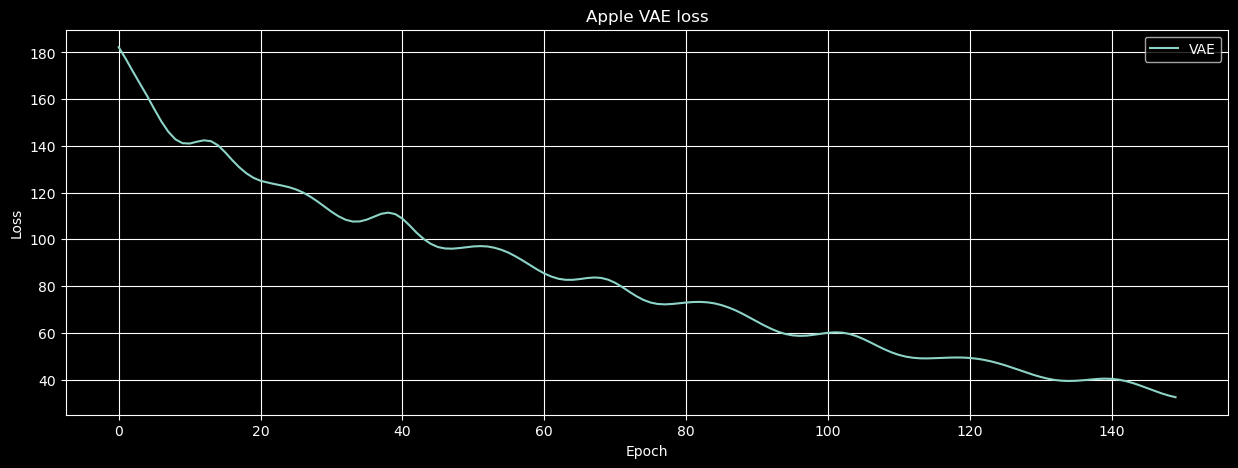

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(hist, label='VAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title(f'{target} VAE loss')
plt.savefig(f'images/{target} VAE loss.png', dpi=300, bbox_inches='tight')

In [7]:
model.eval()
_, VAE_X, X_mu, X_var = model(torch.from_numpy(X).float().to(device))
VAE_train_x, VAE_test_x = VAE_X[:split], VAE_X[split:]
train_x_mu, test_x_mu = X_mu[:split], X_mu[split:]
train_x_var, test_x_var = X_var[:split], X_var[split:]

In [8]:
def sliding_window(x, y, window, n_gen=1):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0] - n_gen):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + n_gen]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [9]:
X = np.concatenate((X, VAE_X.cpu().detach().numpy()), axis = 1)
train_x, test_x = X[:split], X[split:]

In [10]:
num_days_for_predict = 10
num_days_to_predict = 1

In [11]:
# train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, num_days_for_predict, num_days_to_predict)
# test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, num_days_for_predict, num_days_to_predict)
# print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
# print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')
# train_index = dataset.index[num_days_for_predict:len(train_x_slide)+num_days_for_predict]
# test_index = dataset.index[len(train_x_slide)+num_days_for_predict*2+num_days_to_predict*2:]

X_slide, y_slide, y_gan = sliding_window(X, Y, num_days_for_predict, num_days_to_predict)
train_x_slide, test_x_slide = X_slide[:split], X_slide[split:]
train_y_slide, test_y_slide = y_slide[:split], y_slide[split:]
train_y_gan, test_y_gan = y_gan[:split], y_gan[split:]
train_index = dataset.index[num_days_for_predict:len(train_x_slide)+num_days_for_predict]
test_index = dataset.index[len(train_x_slide)+num_days_for_predict:-num_days_to_predict]

In [12]:
from utils.model import Generator, Discriminator

In [60]:
batch_size = 128

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = True)

modelG = Generator(
    input_size=train_x.shape[-1],
    output_size=num_days_to_predict
).to(device)
modelD = Discriminator(
    input_size=num_days_for_predict+num_days_to_predict,
).to(device)

criterion = nn.BCELoss()


In [61]:
learning_rate = 0.00002
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate)

In [62]:
num_epochs = 100

In [63]:
histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0

criterion = nn.BCELoss()

modelG.train()
for epoch in tqdm(range(num_epochs)):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:

        modelD.zero_grad()
        modelG.zero_grad()

        x = x.to(device)
        y = y.to(device)

        fake_data = torch.cat([y[:, :num_days_for_predict, :], modelG(x).unsqueeze(2)], axis=1)
        
        real_output = modelD(y)
        fake_output = modelD(fake_data)
        
        real_labels = torch.ones_like(real_output, device=device)
        fake_labels = torch.zeros_like(fake_output ,device=device)

        lossD = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)
        loss_D.append(lossD.item())

        optimizerD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()

        fake_output = modelD(fake_data)

        lossG = criterion(fake_output, real_labels)
        loss_G.append(lossG.item())

        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    # print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


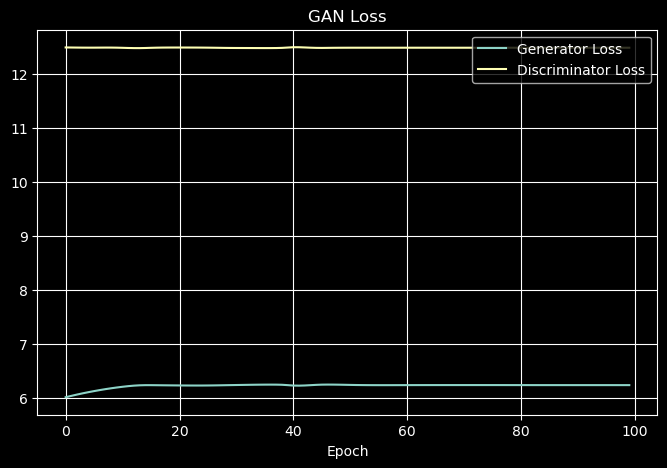

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(histG, label='Generator Loss')
plt.plot(histD, label='Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc = 'upper right')
plt.savefig(f'images/{target} GAN Loss.png', dpi=300, bbox_inches='tight')

In [65]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.detach().cpu())[:, 0]

y_test_true = y_scaler.inverse_transform(test_y_slide.reshape(-1, 1))
y_test_pred = y_scaler.inverse_transform(pred_y_test.detach().cpu())[:, 0]

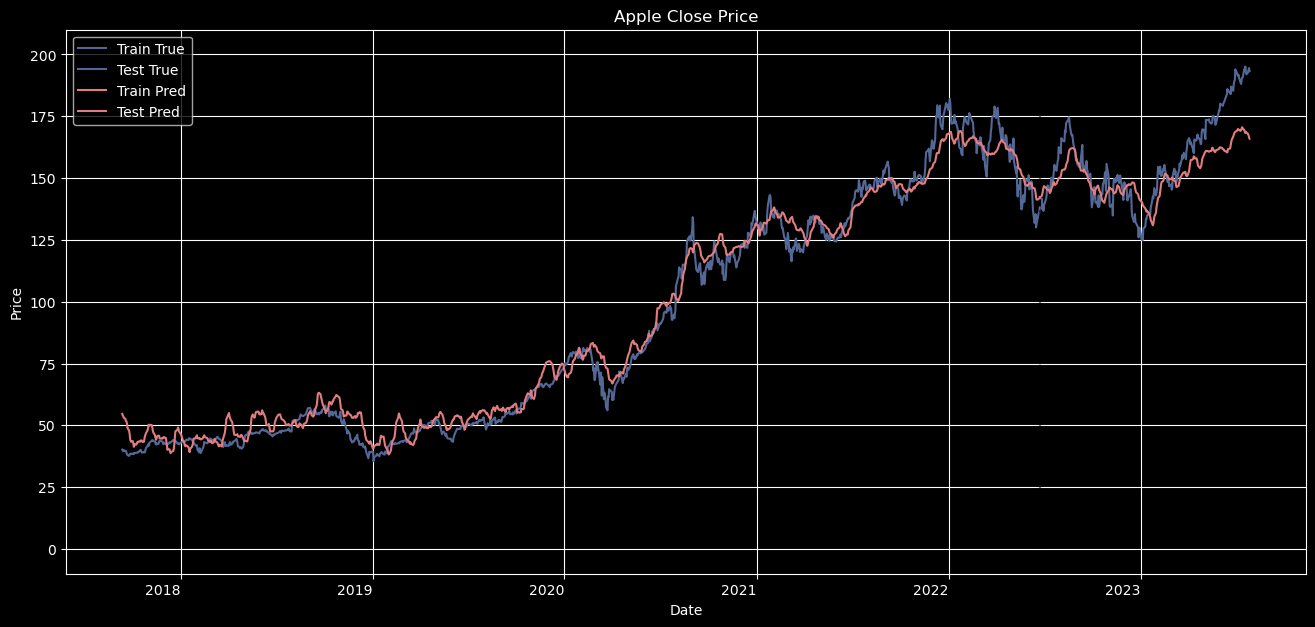

In [66]:
pd.Series(y_train_true.flatten(), index=train_index).plot(figsize=(16,8),label=f'Train True', color='#536897')
pd.Series(y_test_true.flatten(), index=test_index).plot(figsize=(16,8),label=f'Test True', color='#536897')
pd.Series(y_train_pred.flatten(), index=train_index).plot(figsize=(16,8),label=f'Train Pred', color='#E17D81')
pd.Series(y_test_pred.flatten(), index=test_index).plot(figsize=(16,8),label=f'Test Pred', rot=0, color='#E17D81')
plt.plot((train_index[-1], train_index[-1]), (0, 200), color='black', linestyle='--', alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{target} Close Price')
plt.savefig(f'images/{target}_prediction.png', bbox_inches='tight', dpi=300)

Training dataset RMSE:7.400876034353861


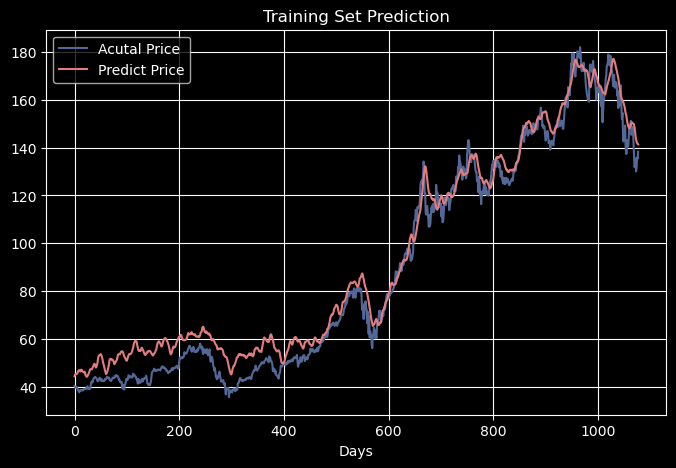

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(y_train_true, color='#536897', label='Acutal Price')
plt.plot(y_train_pred, color='#E17D81', label='Predict Price')
plt.title('Training Set Prediction')
plt.xlabel('Days')
# original_xticks = plt.xticks()[0]
# original_xticks = original_xticks[original_xticks >= 0].astype(int)
# plt.xticks(original_xticks, [d.date() for d in dataset.index[original_xticks]])
plt.legend()
# plt.xlim([800, 1000])
plt.grid()
plt.savefig(f'images/{target} train_set_prediction.png', dpi=300, bbox_inches='tight')

RMSE = mean_squared_error(y_train_true, y_train_pred, squared=False)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:6.58186266618916


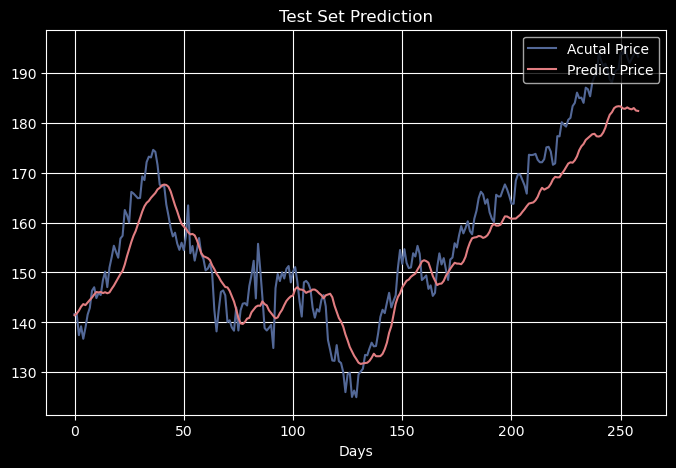

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(y_test_true, color='#536897', label='Acutal Price')
plt.plot(y_test_pred, color='#E17D81', label='Predict Price')
plt.title('Test Set Prediction')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
plt.grid()
# plt.xlim([0, len(y_test_true)])
plt.savefig(f'images/{target} test_set_prediction.png', dpi=300, bbox_inches='tight')

RMSE = mean_squared_error(y_test_true, y_test_pred, squared=False)
print(f'Testing dataset RMSE:{RMSE}')

In [30]:
mean_squared_error(y_train_true[1:], y_train_true[:-1], squared=False)

2.1243746778531993

: 